**1. Load and Inspect Dataset :**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')


**2.  Data Cleaning and Preprocessing :**

In [2]:
# clean total charges and convert it to numeric and impute
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# drop customerID
df.drop('customerID', axis=1, inplace=True)

# binary encoding
binary_map = {'Yes': 1, 'No': 0}
for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    df[col] = df[col].map(binary_map)
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# cleaning service columns
internet_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                         'TechSupport', 'StreamingTV', 'StreamingMovies']
df[internet_service_cols] = df[internet_service_cols].replace({'No internet service': 'No'})
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})

# encode remaining services
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies']
df[service_cols] = df[service_cols].replace(binary_map)


/tmp/ipython-input-2-2637259467.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
/tmp/ipython-input-2-2637259467.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[service_cols] = df[service_cols].replace(binary_map)


**3. Feature Engineering (custom) :**

In [3]:
# total services used
df['TotalServices'] = df[service_cols].sum(axis=1)

# tenure group
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-12', '12-24', '24-48', '48-60', '60-72'])

# charges per service
df['MonthlyChargesPerService'] = df['MonthlyCharges'] / df['TotalServices'].replace(0, 1)
df['TotalChargesPerService'] = df['TotalCharges'] / df['TotalServices'].replace(0, 1)

# autoPay from PaymentMethod
df['AutoPay'] = df['PaymentMethod'].apply(lambda x: 1 if 'automatic' in x.lower() else 0)

# senior group
df['SeniorGroup'] = df['SeniorCitizen'].apply(lambda x: 'Senior' if x == 1 else 'Non-Senior')

# one-hot encode remaining categoricals
df = pd.get_dummies(df, columns=['Contract', 'PaymentMethod', 'InternetService', 'tenure_group', 'SeniorGroup'], drop_first=True)


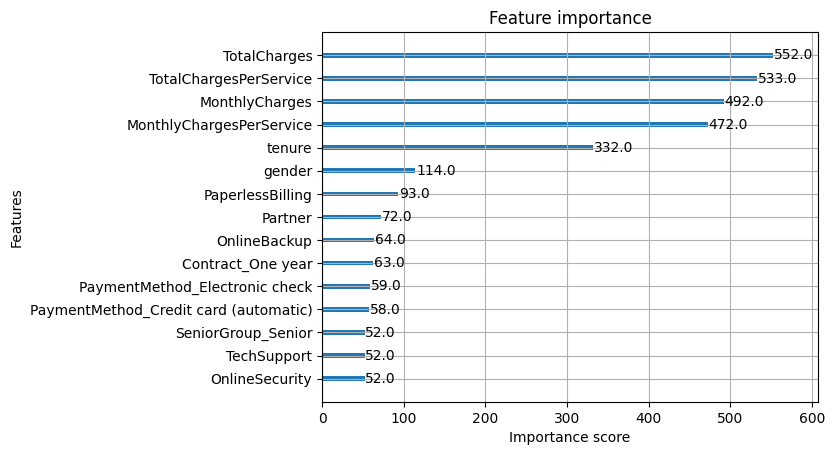

In [9]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model_bal, max_num_features=15)
plt.show()

**4. Feature Selection :**

In [11]:
import pandas as pd

# Get feature importance values
importance = xgb_model_bal.feature_importances_

# Map to feature names
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(features_df.head(15))  # Top 15 features


                                  Feature  Importance
23         PaymentMethod_Electronic check    0.250142
25            InternetService_Fiber optic    0.133992
1                           SeniorCitizen    0.093163
21                      Contract_Two year    0.059999
7                          OnlineSecurity    0.057651
3                              Dependents    0.033371
10                            TechSupport    0.030100
20                      Contract_One year    0.027916
26                     InternetService_No    0.025528
22  PaymentMethod_Credit card (automatic)    0.024607
31                     SeniorGroup_Senior    0.024394
5                            PhoneService    0.022572
4                                  tenure    0.021193
8                            OnlineBackup    0.021173
24             PaymentMethod_Mailed check    0.014884


**4. Model Training & Evaluation**

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb


# Apply SMOTE balancing

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


# Train XGBoost classifier

xgb_model_bal = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model_bal.fit(X_train_bal, y_train_bal)


#  Cross-validation (5-fold CV)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(xgb_model_bal, X_train_bal, y_train_bal, cv=cv, scoring='accuracy')
cv_auc = cross_val_score(xgb_model_bal, X_train_bal, y_train_bal, cv=cv, scoring='roc_auc')

print("Cross-Validation Accuracy Scores:", cv_accuracy)
print("Mean CV Accuracy:", cv_accuracy.mean())
print("Cross-Validation ROC AUC Scores:", cv_auc)
print("Mean CV ROC AUC:", cv_auc.mean())


# Evaluate on Test Set

y_pred = xgb_model_bal.predict(X_test)
y_prob = xgb_model_bal.predict_proba(X_test)[:, 1]

print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Cross-Validation Accuracy Scores: [0.8442029  0.8423913  0.84963768 0.85740181 0.84531722]
Mean CV Accuracy: 0.84779018345812
Cross-Validation ROC AUC Scores: [0.93094209 0.92808029 0.93303155 0.93516815 0.92658407]
Mean CV ROC AUC: 0.9307612286267885

Test Set Evaluation:
Accuracy: 0.7693399574166075
ROC AUC Score: 0.8076855511638119


**5. Visualisation :**

/tmp/ipython-input-25-1340837486.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=features_df.head(15), x='Importance', y='Feature', palette='viridis')


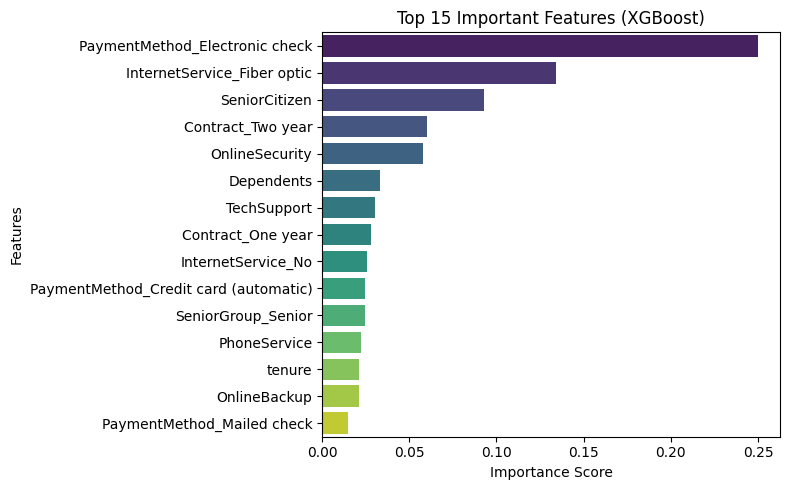

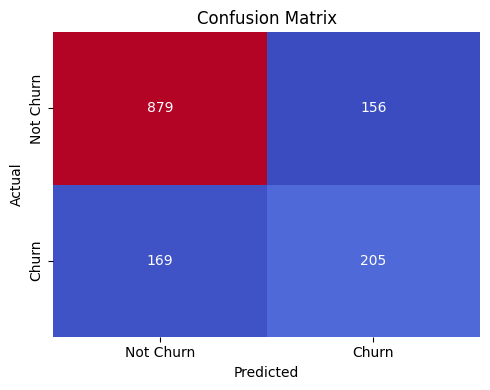

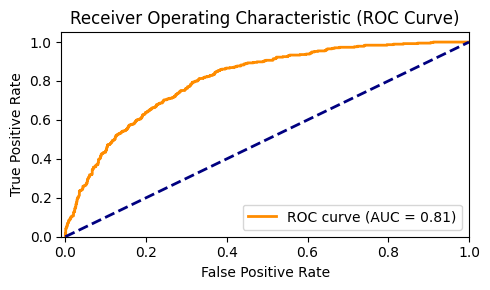

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc


# Feature Importance Plot

importance = xgb_model_bal.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=features_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Important Features (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


# Confusion Matrix Heatmap

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC Curve)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

**6. Visualisations for features based on different features :**

/tmp/ipython-input-29-2527230016.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_original['TotalCharges'].fillna(df_original['TotalCharges'].median(), inplace=True)
/tmp/ipython-input-29-2527230016.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_original[service_cols] = df_original[se

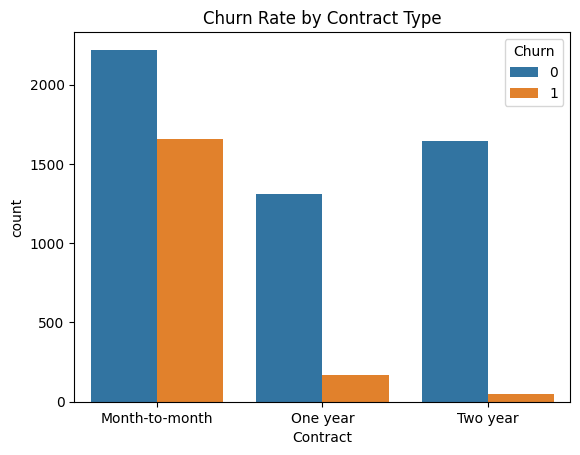

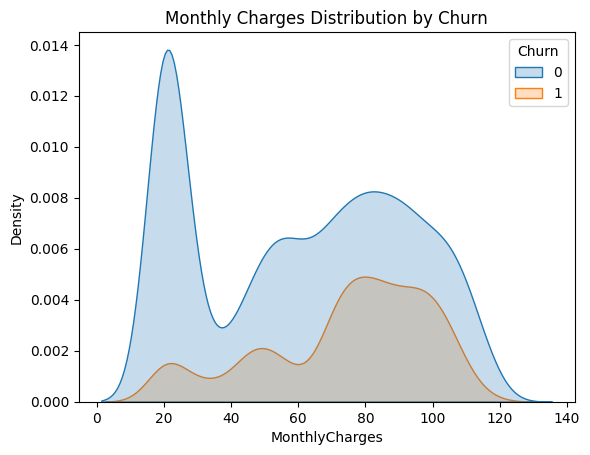

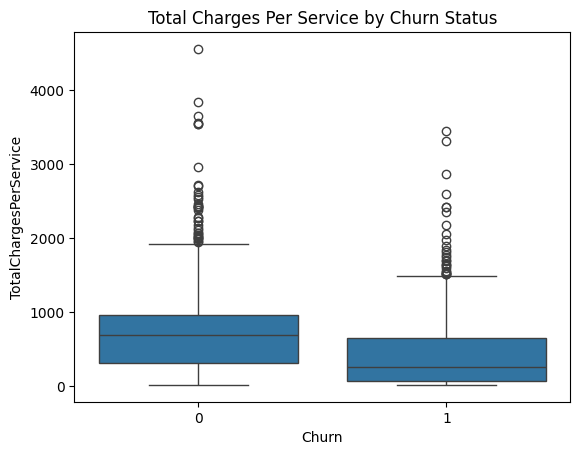

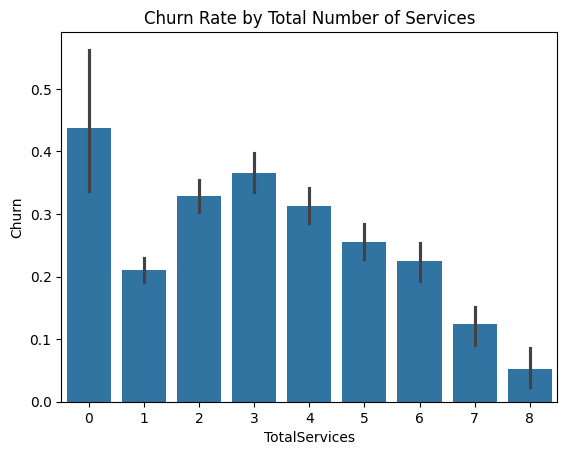

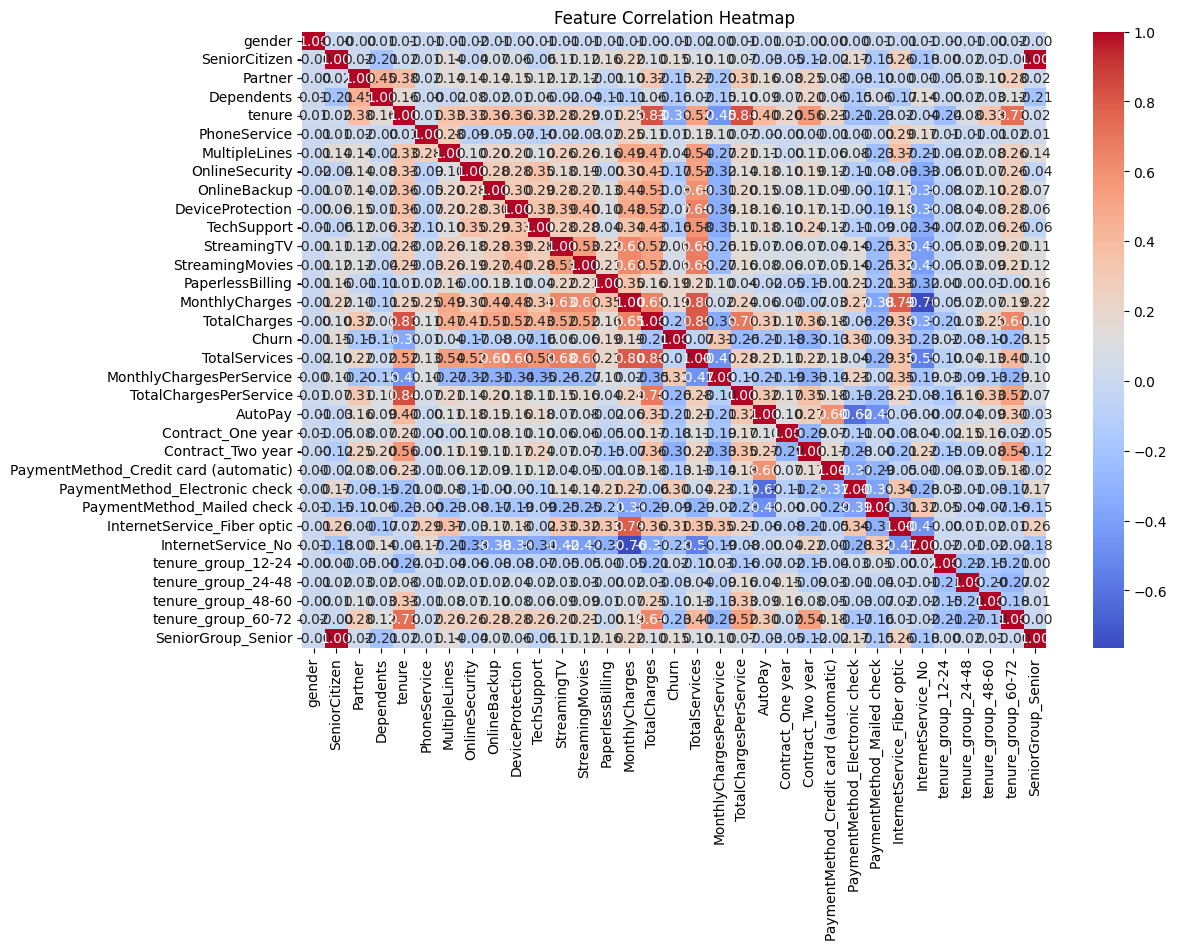

In [29]:
# churn rates across different categories
# Use the original df before one-hot encoding for categorical plots
df_original = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# clean total charges and convert it to numeric and impute
df_original['TotalCharges'] = pd.to_numeric(df_original['TotalCharges'], errors='coerce')
df_original['TotalCharges'].fillna(df_original['TotalCharges'].median(), inplace=True)

# drop customerID
df_original.drop('customerID', axis=1, inplace=True)

# binary encoding
binary_map = {'Yes': 1, 'No': 0}
for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    df_original[col] = df_original[col].map(binary_map)
df_original['gender'] = df_original['gender'].map({'Male': 1, 'Female': 0})

# cleaning service columns
internet_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                         'TechSupport', 'StreamingTV', 'StreamingMovies']
df_original[internet_service_cols] = df_original[internet_service_cols].replace({'No internet service': 'No'})
df_original['MultipleLines'] = df_original['MultipleLines'].replace({'No phone service': 'No'})

# encode remaining services
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies']
df_original[service_cols] = df_original[service_cols].replace(binary_map)

# total services used
df_original['TotalServices'] = df_original[service_cols].sum(axis=1)

# tenure group
df_original['tenure_group'] = pd.cut(df_original['tenure'], bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-12', '12-24', '24-48', '48-60', '60-72'])

# charges per service
df_original['MonthlyChargesPerService'] = df_original['MonthlyCharges'] / df_original['TotalServices'].replace(0, 1)
df_original['TotalChargesPerService'] = df_original['TotalCharges'] / df_original['TotalServices'].replace(0, 1)

# autoPay from PaymentMethod
df_original['AutoPay'] = df_original['PaymentMethod'].apply(lambda x: 1 if 'automatic' in x.lower() else 0)

# senior group
df_original['SeniorGroup'] = df_original['SeniorCitizen'].apply(lambda x: 'Senior' if x == 1 else 'Non-Senior')


sns.countplot(x='Contract', hue='Churn', data=df_original)
plt.title('Churn Rate by Contract Type')
plt.show()

# monthly charges distribution by churn
sns.kdeplot(data=df_original, x='MonthlyCharges', hue='Churn', fill=True)
plt.title('Monthly Charges Distribution by Churn')
plt.show()

# total charges per service
sns.boxplot(x='Churn', y='TotalChargesPerService', data=df_original)
plt.title('Total Charges Per Service by Churn Status')
plt.show()

# churn rate by number of services
sns.barplot(x='TotalServices', y='Churn', data=df.replace({'Churn': {'Yes': 1, 'No': 0}}))
plt.title('Churn Rate by Total Number of Services')
plt.show()

# correlations between numeric features
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

**7. Exporting the final predictions :**

In [31]:
# Predict probabilities and final classes
y_probs = xgb_model_bal.predict_proba(X_test)[:, 1]   # Probability of Churn = 1
y_pred = xgb_model_bal.predict(X_test)                # Predicted class (0 or 1)

# Create a DataFrame with predictions
# Reload the original dataset to get customerID
df_original = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

predictions_df = pd.DataFrame({
    'CustomerID': df_original.loc[X_test.index, 'customerID'],  # Use customerID from original df
    'PredictedChurn': y_pred,
    'ChurnProbability': y_probs
})

# Save to CSV and download
from google.colab import files
predictions_df.to_csv('churn_predictions.csv', index=False) # Save the dataframe to csv
files.download('churn_predictions.csv')

print("Predictions exported to 'churn_predictions.csv'")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions exported to 'churn_predictions.csv'
